# Bootstrap Basic

Jun Song

추가로 필요한 라이브러리: ``ISLP``

In [8]:
import numpy as np

from ISLP import load_data


In [4]:
# Load the Portfolia Dataset
Portfolio = load_data('Portfolio')
Portfolio

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983
...,...,...
95,0.479091,1.454774
96,-0.535020,-0.399175
97,-0.773129,-0.957175
98,0.403634,1.396038


## Estimate the standard error of estimator $\hat{\alpha}$

데이터가 주어졌을 때 $\hat{\alpha}$는 다음과 같이 계산된다.
$$
\hat{\alpha} = \frac{\hat{\sigma}^{2}_{Y} - \hat{\sigma}_{XY}}{\hat{\sigma}^{2}_{X} + \hat{\sigma}^{2}_{Y} - 2\hat{\sigma}_{XY}}$$

Resampling 을 하며 $\hat{\alpha}$를 계산할 예정이므로, estimator 함수를 만들 때 index 정보를 기반으로 계산되는 함수를 만들자.

In [6]:
def alpha_func(D, idx):
   cov_ = np.cov(D[['X','Y']].loc[idx], rowvar=False)
   return ((cov_[1,1] - cov_[0,1]) /
           (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))

만약에 모든 데이터를 사용해서 $\alpha$ 를 추정한다면

In [9]:
alpha_func(Portfolio, range(100))

0.57583207459283

A single bootstrap sample은 다음과 같다. 1,..., 100 (100개의 관측치가 있을 경우) 개의 데이터 중 100개의 데이터를 중복 가능하게 random 추출 (with replacement)

In [10]:
rng = np.random.default_rng(0)
rng.choice(100, 100, replace=True)

array([85, 63, 51, 26, 30,  4,  7,  1, 17, 81, 64, 91, 50, 60, 97, 72, 63,
       54, 55, 93, 27, 81, 67,  0, 39, 85, 55,  3, 76, 72, 84, 17,  8, 86,
        2, 54,  8, 29, 48, 42, 40,  2,  0, 12,  0, 67, 52, 64, 25, 61, 76,
       38, 46, 99, 80, 98, 37, 68, 95, 65, 84, 68, 70, 38, 87, 13, 57, 72,
       84, 52, 37, 31, 42, 48, 71, 88,  7, 93, 53, 35, 67, 57, 25, 32, 71,
       59, 50, 33, 76, 39, 32, 89, 26, 22, 71, 62,  4,  8, 37, 83])

In [11]:
# one of \hat{alpha} from a bootstrap sample
rng = np.random.default_rng(0)
alpha_func(Portfolio,
           rng.choice(100,
                      100,
                      replace=True))

0.6074452469619004

그럼 이제 Bootstrap resampling 을 통해 주어진 estimator (alpha hat estimator) 의 SE를 계산하는 함수를 만들어보자.
**Input argument**
- ``func(D, idx)``: Estimator
- ``D``: Dataset
- ``B``: number of bootstrap samples
- ``seed``: initial seed for the resampling procedure

$\hat{\alpha}_1, \ldots, \hat{\alpha}_B$ 로부터 평균과 분산 계산은 다음과 같다.
$$
\bar{\hat{\alpha}}= B^{-1}\sum_{i=1}^B \hat{\alpha}_i
$$
$$
\hat{\sigma}^2_{\hat{\alpha}} = B^{-1} \sum_{i=1}^B (\hat{\alpha}_i-\bar{\hat{\alpha}})^2 = B^{-1}\sum_{i=1}^B \hat{\alpha}_i^2 - \bar{\hat{\alpha}}^2
$$
여기서, 표본 분산의 경우 $B-1$로 나누는 것이 일반적이나, bootstrap sample size $B$ 가 매우 큰 경우 그 차이는 미미하다. 편의상 $B$로 계산.

In [12]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

Notice the use of ``_`` as a loop variable in ``for _ in range(B)``. This is often used if the value of the counter is unimportant and simply makes sure the loop is executed ``B`` times.

In [13]:
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE

0.09118176521277699

The final output shows that the bootstrap estimate for $SE(\hat{\alpha})$ is 0.0912.

## Bootstrap SE estimation in Linear Regression

In [14]:
df = load_data('Auto')
import statsmodels.api as sm
X = df['horsepower']
y = df['mpg']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           7.03e-81
Time:                        19:54:51   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

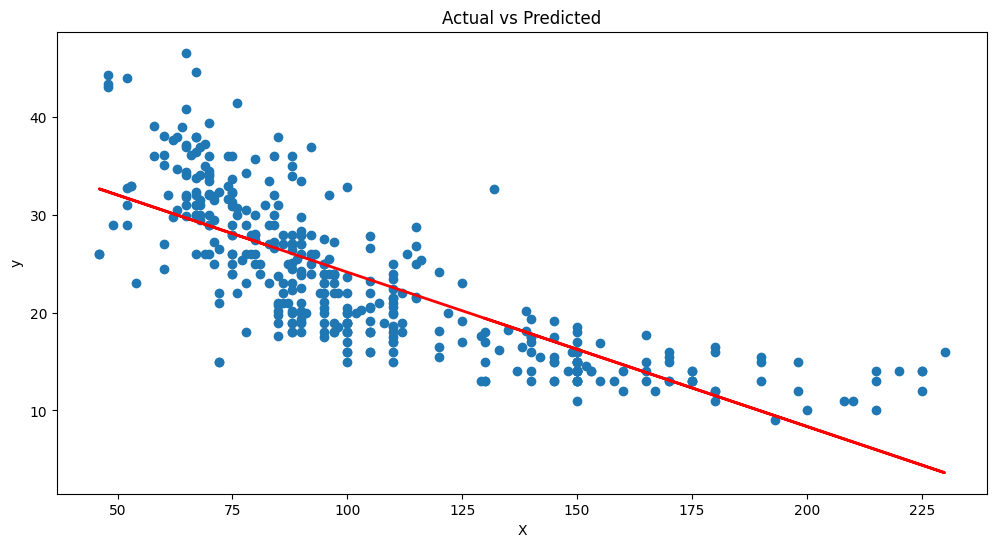

In [16]:
import matplotlib.pyplot as plt

# Predict values
y_pred = est2.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(df['horsepower'], df['mpg'], 'o')           # scatter plot showing actual data
plt.plot(df['horsepower'], y_pred, 'r', linewidth=2)   # regression line
plt.title('Actual vs Predicted')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

Y와 X의 선형성 가정이 만족되지 않은 것을 확인 가능

In [19]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2)
X_arr = np.array(X).reshape(-1,1)
xp = polynomial_features.fit_transform(X_arr)
xp

array([[1.0000e+00, 1.3000e+02, 1.6900e+04],
       [1.0000e+00, 1.6500e+02, 2.7225e+04],
       [1.0000e+00, 1.5000e+02, 2.2500e+04],
       ...,
       [1.0000e+00, 8.4000e+01, 7.0560e+03],
       [1.0000e+00, 7.9000e+01, 6.2410e+03],
       [1.0000e+00, 8.2000e+01, 6.7240e+03]])

In [20]:
poly_model = sm.OLS(y, xp).fit()
ypred = poly_model.predict(xp) 
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           5.40e-99
Time:                        19:57:41   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.9001      1.800     31.604      0.000      53.360      60.440
x1            -0.4662      0.031    -14.978      0.000      -0.527      -0.405
x2             0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

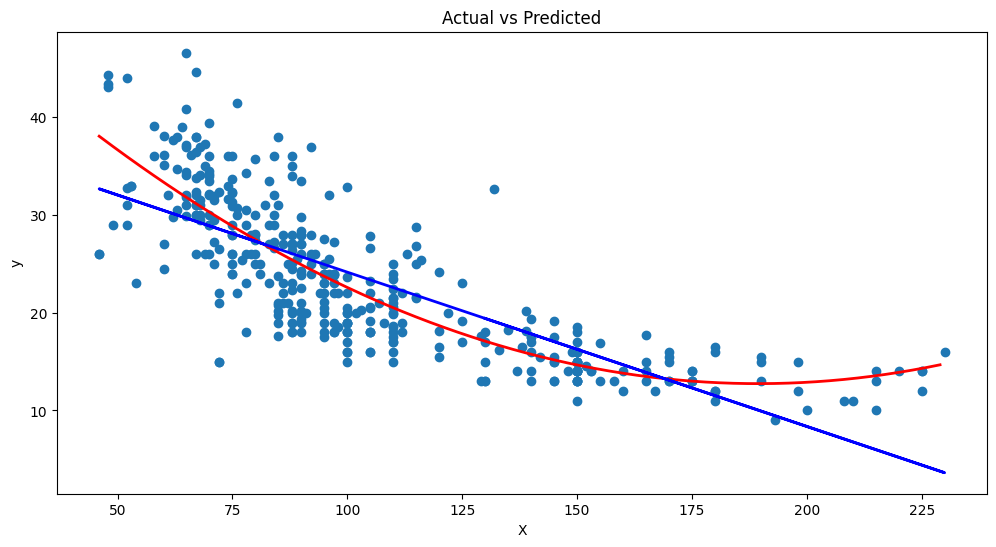

In [24]:
xgrid= np.arange(X_arr.min(), X_arr.max()).reshape(-1,1)
xgrid_poly = polynomial_features.transform(xgrid)
# Predict values
y_pred = poly_model.predict(xgrid_poly)

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(df['horsepower'], df['mpg'], 'o')           # scatter plot showing actual data
plt.plot(xgrid, y_pred, 'r', linewidth=2)   # polynomial regression line
plt.plot(df['horsepower'], est2.predict(), 'b', linewidth=2)   # linear regression line
plt.title('Actual vs Predicted')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

In [39]:
# polynomial_features= PolynomialFeatures(degree=2)
# X_arr = np.array(X).reshape(-1,1)
# xp = polynomial_features.fit_transform(X_arr)

def boot_OLS(D, idx):
    D_ = D.loc[idx]
    y_ = D_['mpg']
    X_ = D_['horsepower']
    
    X2_ = sm.add_constant(X_)
    return sm.OLS(y_, X2_).fit().params

In [42]:
hp_se = boot_SE(boot_OLS,
                D=df,
                B=1000,
                seed=0)
hp_se

const         0.857854
horsepower    0.007458
dtype: float64

In [65]:
print('const', est2.summary().tables[1].data[1][2])
print('horsepower', est2.summary().tables[1].data[2][2])


const     0.717
horsepower     0.006


부트스랩을 사용하여 얻은 추정치와 다소 다르다. 이것이 문제일까? 
- linear regression 은 가정 하에 $\hat{\beta}$의 standard error 를 계산하는 공식이 있다.
- 또한 그 공식은 $\sigma^2$의 추정을 근간으로 하며, 이는 선형 모델이 확실하다는 가정에 의존.
- 오차가 비선형인건 쉽게 확인 가능 (가정 깨짐)
- 2차 polynomial regression 에서 비교했을 시, 보다 더 정확할 가능성이 있다고 보임. 

확인해보자.

In [66]:
def boot_quad(D, idx):
    D_ = D.loc[idx]
    y_ = D_['mpg']
    X_ = D_['horsepower']
    poly_features= PolynomialFeatures(degree=2)
    X_arr = np.array(X_).reshape(-1,1)
    X2_ = poly_features.fit_transform(X_arr)
    return sm.OLS(y_, X2_).fit().params

In [69]:
hp_quad_se = boot_SE(boot_quad,
                D=df,
                B=1000,
                seed=0)
hp_quad_se

const    2.079056
x1       0.033209
x2       0.000120
dtype: float64

In [68]:
print('const', poly_model.summary().tables[1].data[1][2])
print('horsepower', poly_model.summary().tables[1].data[2][2])
print('horsepower^2', poly_model.summary().tables[1].data[3][2])


const     1.800
horsepower     0.031
horsepower^2     0.000
